In [ ]:
%cd /afs/crc.nd.edu/user/m/msaebi/Public/chemistry/yield_rxn

In [1]:
import argparse
import os
import pickle
import pandas as pd
import numpy as np
import warnings   
import seaborn as sns
from collections import defaultdict
import matplotlib.pyplot as plt

from sklearn.exceptions import DataConversionWarning
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.preprocessing import StandardScaler



In [4]:
parser = argparse.ArgumentParser()
parser.add_argument("-dn", "--dataset_name", type=str, default="dy",required=True, help="dataset name. Options: az (AstraZeneca),dy (Doyle),su (Suzuki)")
parser.add_argument("-dp","--dataset_path", type=str, default='./data/', help="dataset name")
parser.add_argument("-rdkit", "--use_rdkit_feats", default=1, type=int, help="Use rdkit discriptors or not")
parser.add_argument("-od", "--output_dir", default='rf_results', type=str, help="Output dir for writing features and RF scores")
parser.add_argument("-th", "--feat_threshold",  type=float, default=0.0001, help="Threshold for feature importance to discard features")
parser.add_argument("-ne", "--n_estimators",  type=float, default=1000, help="Number of trees in RF model")
parser.add_argument("-md", "--max_depth",  type=float, default=10, help="Max depth in RF trees")
parser.add_argument("-rs", "--random_state",  type=float, default=0, help="Random state for RF model")
parser.add_argument("-plt", "--plot_yield_dist",  type=bool, default=False, help="Plot the yield distribution")


args = parser.parse_args(args=["-rdkit","1",
                               "-dn","az",
                              "-od","rf_results"])

In [5]:

data_type=args.dataset_name
use_rdkit_features= args.use_rdkit_feats
ext = '_no_rdkit' if not use_rdkit_features else '_rdkit'

#inputs
processed_path = os.path.join(args.dataset_path,data_type,'processed')

input_data_file = os.path.join(processed_path,''.join([data_type,ext ,'.csv']))
input_split_idx_file = os.path.join(processed_path,'train_test_idxs.pickle')


#outputs
output_path = os.path.join(args.dataset_path,data_type,args.output_dir)
if not os.path.exists(output_path):
    os.mkdir(output_path)
features_fn= os.path.join(output_path,'selected_feats.txt')
results_fn= os.path.join(output_path,'rf_results.csv')


print("\n\nReading data from: ",input_data_file)
print("Using rdkit features!") if use_rdkit_features else print("Not using rdkit features!")



Reading data from:  ./data/az/processed/az_rdkit.csv
Using rdkit features!


In [6]:
df=pd.read_csv(input_data_file,index_col=0)
smiles_features = ["reactant_smiles","solvent_smiles","base_smiles","product_smiles"]
df.drop(smiles_features, axis=1,inplace=True)
print(f"Raw data frame shape: {df.shape}")
if args.plot_yield_dist:
    print(f"Plotting yield distibution:")
    df['yield'].plot(kind='hist',bins=12)

Raw data frame shape: (750, 1220)


In [7]:
def split_scale_data(df,split_set_num,idx_dict,label_name):
    """
    split the raw data into train and test using
    pre-writtten indexes. Then standardize the train
    and test set.
    """

    train_set = df.iloc[idx_dict['train_idx'][split_set_num]]
    test_set = df.iloc[idx_dict['test_idx'][split_set_num]]


    y_train, y_test = train_set.pop(label_name), test_set.pop(label_name)
    train_set.pop('id'), test_set.pop('id')
    x_train, x_test = train_set, test_set

    scaler = StandardScaler()

    x_train_scaled = pd.DataFrame(scaler.fit_transform(x_train),columns = x_train.columns)
    x_test_scaled = pd.DataFrame(scaler.transform(x_test),columns = x_test.columns)
    return x_train_scaled, x_test_scaled , y_train, y_test



def get_sorted_feat_importances(feat_names,feat_importances):
    """
    sort the feature names based on RF feature importances
    and return the sorted feat names as well as pair:
    (feat_name, score)
    """
    sorted_idx = (-feat_importances).argsort()#[:n]

    sorted_feat_names = [feat_names[i] for i in sorted_idx]
    sorted_feat_importances =feat_importances[sorted_idx]
    final_feat_importances =list( zip(sorted_feat_names,sorted_feat_importances))

    return sorted_feat_names,final_feat_importances

In [11]:
selected_features=set()
result_dict=defaultdict(lambda: defaultdict(list))
with open(input_split_idx_file, 'rb') as handle:
    idx_dict = pickle.load(handle)

print()
#for split_set_num in range(1,len(idx_dict['train_idx'])+1):
for split_set_num in range(1,len(idx_dict['train_idx'])+1):

    result_dict[split_set_num]['model_num']=split_set_num 
    
    x_train_scaled, x_test_scaled , y_train, y_test= split_scale_data(df,split_set_num,idx_dict,'yield')
    rf = RandomForestRegressor(n_estimators = args.n_estimators, random_state = args.random_state ,max_depth=args.max_depth)
    rf.fit(x_train_scaled ,y_train)
    
    
    feat_names = list(x_train_scaled.columns) ##get the top features
    sorted_feat_names, sorted_feat_importances = get_sorted_feat_importances(feat_names,rf.feature_importances_)    
    for feat,score in sorted_feat_importances:
        result_dict[split_set_num][feat]=score
        if score >= args.feat_threshold:
            selected_features.add(feat)

    y_pred_train = rf.predict(x_train_scaled) 
    y_pred_test = rf.predict(x_test_scaled)
    
    train_r2 = round(100*r2_score(y_train,y_pred_train),3)
    test_r2 = round(100*r2_score(y_test,y_pred_test ),3)
    
    result_dict[split_set_num]['train_r2'] = round(r2_score(y_train,y_pred_train),3)
    result_dict[split_set_num]['test_r2'] = round(r2_score(y_test,y_pred_test ),3)
    
    print(f'\nModel number: {split_set_num}')
    print(f'Mean Absolute Train R2: { train_r2}')
    print(f'Mean Absolute Test R2: { test_r2}')



Model number: 1
Mean Absolute Train R2: 87.688
Mean Absolute Test R2: 24.095

Model number: 2
Mean Absolute Train R2: 88.256
Mean Absolute Test R2: 28.786

Model number: 3
Mean Absolute Train R2: 88.385
Mean Absolute Test R2: 18.357

Model number: 4
Mean Absolute Train R2: 87.613
Mean Absolute Test R2: 27.954

Model number: 5
Mean Absolute Train R2: 89.148
Mean Absolute Test R2: 19.952

Model number: 6
Mean Absolute Train R2: 86.845
Mean Absolute Test R2: 26.72

Model number: 7
Mean Absolute Train R2: 86.174
Mean Absolute Test R2: 31.273

Model number: 8
Mean Absolute Train R2: 86.505
Mean Absolute Test R2: 26.564

Model number: 9
Mean Absolute Train R2: 87.268
Mean Absolute Test R2: 29.222

Model number: 10
Mean Absolute Train R2: 86.334
Mean Absolute Test R2: 27.926


In [9]:
#Write the model summary results and selecyed features
dp= pd.DataFrame.from_dict(result_dict, orient='index',columns=['model_num','train_r2','test_r2']+sorted_feat_names)
summary= dp.describe().loc[['mean','std']]
dp.append(summary)



,model_num,train_r2,test_r2,reaction_volume,reaction_scale,base_amount,halide_SlogP_VSA10,halide_MolLogP,temperature,product_VSA_EState4,...,solvent_PEOE_VSA14,solvent_BCUT2D_MWHI,ligand_PEOE_VSA5,ligand_NumAromaticHeterocycles,ligand_NumSaturatedHeterocycles,ligand_fr_Ar_N,ligand_fr_furan,amine_fr_aldehyde,solvent_BCUT2D_MRHI,ligand_.O3_NMR_shift
1,1.00000,0.877000,0.241000,0.114526,0.053729,0.023564,0.004934,0.003938,0.006754,0.002939,...,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,8.866095e-07,0.0,4.686631e-08,9.177459e-09,0.000000e+00,0.0
2,2.00000,0.883000,0.288000,0.099209,0.086906,0.017605,0.008880,0.019995,0.006716,0.005011,...,0.000000e+00,2.642647e-08,0.000000,0.000000e+00,5.746913e-08,0.0,0.000000e+00,4.582083e-08,0.000000e+00,0.0
3,3.00000,0.884000,0.184000,0.171926,0.034869,0.018016,0.007406,0.011724,0.008072,0.002346,...,5.991141e-06,0.000000e+00,0.000000,0.000000e+00,2.436353e-06,0.0,0.000000e+00,0.000000e+00,5.267740e-07,0.0
4,4.00000,0.876000,0.280000,0.156165,0.024734,0.021061,0.005037,0.009905,0.010635,0.003310,...,0.000000e+00,6.496484e-08,0.000000,0.000000e+00,1.915998e-07,0.0,0.000000e+00,8.544539e-07,8.267572e-07,0.0
5,5.00000,0.891000,0.200000,0.129353,0.043224,0.018988,0.002036,0.006613,0.007394,0.006143,...,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,3.858283e-07,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0
6,6.00000,0.868000,0.267000,0.125669,0.037120,0.033246,0.003289,0.005648,0.006983,0.004408,...,0.000000e+00,3.662081e-09,0.000000,2.646379e-06,2.610654e-08,0.0,0.000000e+00,1.234816e-07,0.000000e+00,0.0
7,7.00000,0.862000,0.313000,0.157342,0.051524,0.024390,0.001671,0.006130,0.007469,0.003346,...,0.000000e+00,4.461602e-09,0.000024,0.000000e+00,1.500014e-06,0.0,0.000000e+00,2.392934e-08,8.154447e-07,0.0
8,8.00000,0.865000,0.266000,0.153619,0.026824,0.021187,0.007403,0.010153,0.009451,0.004121,...,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,8.256066e-06,0.0,0.000000e+00,1.112872e-07,0.000000e+00,0.0
9,9.00000,0.873000,0.292000,0.103915,0.075970,0.045044,0.005213,0.004246,0.009142,0.004230,...,0.000000e+00,1.729819e-04,0.000000,0.000000e+00,7.766215e-06,0.0,1.735830e-07,0.000000e+00,5.970096e-04,0.0
10,10.00000,0.863000,0.279000,0.117656,0.046061,0.022732,0.016167,0.012278,0.010332,0.010141,...,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0


In [10]:
dp

,model_num,train_r2,test_r2,reaction_volume,reaction_scale,base_amount,halide_SlogP_VSA10,halide_MolLogP,temperature,product_VSA_EState4,...,solvent_PEOE_VSA14,solvent_BCUT2D_MWHI,ligand_PEOE_VSA5,ligand_NumAromaticHeterocycles,ligand_NumSaturatedHeterocycles,ligand_fr_Ar_N,ligand_fr_furan,amine_fr_aldehyde,solvent_BCUT2D_MRHI,ligand_.O3_NMR_shift
1,1,0.877,0.241,0.114526,0.053729,0.023564,0.004934,0.003938,0.006754,0.002939,...,0.000000,0.000000e+00,0.000000,0.000000,8.866095e-07,0.0,4.686631e-08,9.177459e-09,0.000000e+00,0.0
2,2,0.883,0.288,0.099209,0.086906,0.017605,0.008880,0.019995,0.006716,0.005011,...,0.000000,2.642647e-08,0.000000,0.000000,5.746913e-08,0.0,0.000000e+00,4.582083e-08,0.000000e+00,0.0
3,3,0.884,0.184,0.171926,0.034869,0.018016,0.007406,0.011724,0.008072,0.002346,...,0.000006,0.000000e+00,0.000000,0.000000,2.436353e-06,0.0,0.000000e+00,0.000000e+00,5.267740e-07,0.0
4,4,0.876,0.280,0.156165,0.024734,0.021061,0.005037,0.009905,0.010635,0.003310,...,0.000000,6.496484e-08,0.000000,0.000000,1.915998e-07,0.0,0.000000e+00,8.544539e-07,8.267572e-07,0.0
5,5,0.891,0.200,0.129353,0.043224,0.018988,0.002036,0.006613,0.007394,0.006143,...,0.000000,0.000000e+00,0.000000,0.000000,3.858283e-07,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0
6,6,0.868,0.267,0.125669,0.037120,0.033246,0.003289,0.005648,0.006983,0.004408,...,0.000000,3.662081e-09,0.000000,0.000003,2.610654e-08,0.0,0.000000e+00,1.234816e-07,0.000000e+00,0.0
7,7,0.862,0.313,0.157342,0.051524,0.024390,0.001671,0.006130,0.007469,0.003346,...,0.000000,4.461602e-09,0.000024,0.000000,1.500014e-06,0.0,0.000000e+00,2.392934e-08,8.154447e-07,0.0
8,8,0.865,0.266,0.153619,0.026824,0.021187,0.007403,0.010153,0.009451,0.004121,...,0.000000,0.000000e+00,0.000000,0.000000,8.256066e-06,0.0,0.000000e+00,1.112872e-07,0.000000e+00,0.0
9,9,0.873,0.292,0.103915,0.075970,0.045044,0.005213,0.004246,0.009142,0.004230,...,0.000000,1.729819e-04,0.000000,0.000000,7.766215e-06,0.0,1.735830e-07,0.000000e+00,5.970096e-04,0.0
10,10,0.863,0.279,0.117656,0.046061,0.022732,0.016167,0.012278,0.010332,0.010141,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0


In [29]:
#Write the model summary results and selecyed features
dp= pd.DataFrame.from_dict(result_dict, orient='index',columns=['model_num','train_r2','test_r2']+sorted_feat_names)
summary= dp.describe().loc[['mean','std']]
dp.append(summary)


print(f"\nWriting selected features to: {features_fn}")
print(f"Writing RFs summary results to: {results_fn}")

dp.to_csv(results_fn)
with open(features_fn,'w') as f:
    f.write(','.join(map(str,selected_features)))

# Old

### Write selected features from the RF model

In [8]:
feats=open('data/'+data_type+'/'+data_type+'_selected_features.txt','w')
feats.write(','.join(map(str,selected_features)))

13102

In [10]:
print('AZ-nordki')
print(f"test: {np.median(test_scores)}, train: {np.median(train_scores)}")
print(f"test-avg: {round(np.mean(test_scores),2)}, test-std: {round(np.std(test_scores),2)}")


print("train_scores: ",train_scores)
print("test_scores: ",test_scores)

AZ-nordki
test: 27.5485, train: 86.2025
test-avg: 26.93, test-std: 3.89
train_scores:  [86.451, 86.244, 86.578, 85.834, 87.19, 86.091, 85.258, 85.071, 87.679, 86.161]
test_scores:  [25.001, 27.57, 27.527, 32.108, 24.591, 25.407, 27.817, 31.368, 17.865, 30.055]


In [7]:
print('AZ-with rdkit')
print(f"test: {np.median(test_scores)}, train: {np.median(train_scores}")
print("train_scores: ",train_scores)
print("test_scores: ",test_scores)

30.075499999999998 86.63499999999999
[86.559, 86.855, 86.379, 86.989, 86.836, 86.606, 86.664, 86.316, 86.861, 86.38]
[33.823, 31.644, 33.669, 32.455, 29.003, 24.274, 21.825, 29.503, 28.518, 30.648]


In [26]:
np.median([90.53,71.15,90.54,94.21,95.37,88.24,92.01,91.16,81.78,87.62])

90.535

In [6]:
print('AZ-no-rdkit')
print(f"test: {np.median(test_scores)}, train: {np.median(train_scores)}")
print(f"test-avg: {round(np.mean(test_scores),2)}, test-std: {round(np.std(test_scores),2)}")


print("train_scores: ",train_scores)
print("test_scores: ",test_scores)

AZ-no-rdkit
test: 26.314999999999998, train: 85.646
test-avg: 27.32, test-std: 3.72
train_scores:  [86.107, 86.134, 85.259, 84.922, 86.827, 85.08, 84.509, 84.871, 86.442, 86.033]
test_scores:  [25.788, 23.098, 24.736, 36.028, 26.108, 26.609, 31.332, 29.342, 23.676, 26.522]


In [6]:
print('DY')
print(f"test: {np.median(test_scores)}, train: {np.median(train_scores}")
print("train_scores: ",train_scores)
print("test_scores: ",test_scores)

91.292 96.791


In [7]:
print('DY-rdkit')
print(f"test: {np.median(test_scores)}, train: {np.median(train_scores)}")
print(f"test-avg: {round(np.mean(test_scores),2)}, test-std: {round(np.std(test_scores),2)}")

print("train_scores: ",train_scores)
print("test_scores: ",test_scores)

DY-rdkit
test: 89.351, train: 95.9245
test-avg: 89.23, test-std: 0.98
train_scores:  [96.145, 95.765, 96.199, 95.582, 96.094, 95.818, 95.801, 95.946, 96.14, 95.903]
test_scores:  [89.471, 90.147, 88.525, 90.089, 88.824, 89.776, 89.231, 90.695, 87.233, 88.304]


In [7]:
print('SU')
print(f"test: {np.median(test_scores)}, train: {np.median(train_scores}")
print("train_scores: ",train_scores)
print("test_scores: ",test_scores)

83.2415 92.52199999999999


In [9]:
print('SU-nordkit')
print(f"test: {np.median(test_scores)}, train: {np.median(train_scores)}")
print(f"test-avg: {round(np.mean(test_scores),2)}, test-std: {round(np.std(test_scores),2)}")


print("train_scores: ",train_scores)
print("test_scores: ",test_scores)

SU-nordkit
test: 79.5995, train: 85.6685
test-avg: 79.68, test-std: 0.78
train_scores:  [85.5, 86.119, 85.692, 85.821, 85.022, 85.895, 86.223, 85.645, 85.382, 85.452]
test_scores:  [79.818, 79.416, 79.074, 79.26, 81.393, 78.668, 78.808, 80.336, 80.245, 79.783]


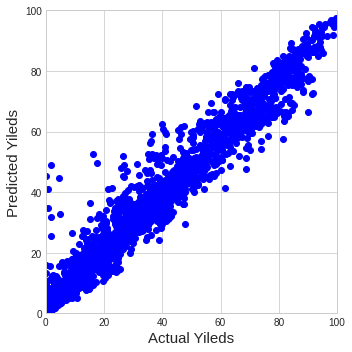

In [21]:
plt.style.use('seaborn-whitegrid')
#ax=plt.figure(figsize=(8,8))
fig, ax = plt.subplots(figsize=(5,5))
#ax=fig.add_axes([0,0,1,1])
ax.scatter(y_train, y_pred, color='b')
ax.set_xlabel('Actual Yileds',fontsize=15)
ax.set_ylabel('Predicted Yileds',fontsize=15)
ax.set_xlim([0,100])
ax.set_ylim([0,100])
plt.tight_layout()
plt.savefig(path+'RF_true_vs_pred_train.png',dpi=300)
plt.show()

In [12]:
# Use the forest's predict method on the test data
predictions = rf.predict(X_test)
# Calculate the absolute errors
errors =r2_score(y_test,predictions )
# Print out the mean absolute error (mae)
print('Mean Absolute Test Error:', round(np.mean(errors), 3))


Mean Absolute Test Error: 0.29


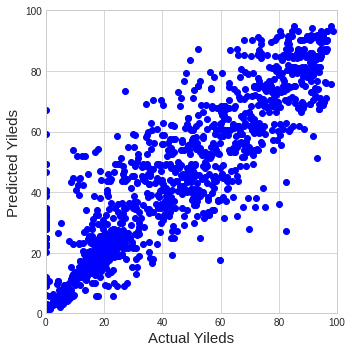

In [12]:
plt.style.use('seaborn-whitegrid')
#ax=plt.figure(figsize=(8,8))
fig, ax = plt.subplots(figsize=(5,5))
#ax=fig.add_axes([0,0,1,1])
ax.scatter(y_test, predictions, color='b')
ax.set_xlabel('Actual Yileds',fontsize=15)
ax.set_ylabel('Predicted Yileds',fontsize=15)
ax.set_xlim([0,100])
ax.set_ylim([0,100])
plt.tight_layout()
plt.savefig(path+'true_vs_pred_test'+rdkit+'.png',dpi=300)
plt.show()

In [40]:
df.shape

(4543, 687)

In [51]:
rf.feature_importances_[100]

0.00017479519106633262

In [52]:
feat_names[100]

'Halide_fr_para_hydroxylation'

In [47]:
n=687
feat_importances = feat_import_dict[0]

sorted_idx = (-feat_importances).argsort()[:n]
feat_names= list(X.columns)

selected_feat_names = [feat_names[i] for i in sorted_idx]
selected_feat_importances =feat_importances[sorted_idx]

feature_subset= []
feat_weight=[]
for i in range(len(sorted_idx)):
    if selected_feat_importances[i]>=0:
        feature_subset.append(selected_feat_names[i])
        if 'solvent' in selected_feat_names[i]:
            print(selected_feat_names[i],selected_feat_importances[i])
        feat_weight.append((selected_feat_names[i],selected_feat_importances[i]))

solvent_MaxAbsPartialCharge 0.005070002364909525
solvent_EState_VSA8 0.004677334360656554
solvent_MaxPartialCharge 0.0033089804984786533
solvent_FpDensityMorgan1 0.0031347691192799027
solvent_FpDensityMorgan3 0.0031023184941281466
solvent_PEOE_VSA1 0.0030434153527292844
solvent_MinAbsPartialCharge 0.0029652323732506213
solvent_FpDensityMorgan2 0.0029077541178992145
solvent_PEOE_VSA9 0.002847581215465326
solvent_MinEStateIndex 0.0027120884378115584
solvent_FractionCSP3 0.0021157399589628576
solvent_TPSA 0.0020611963698014967
solvent_MinPartialCharge 0.0020495983864096097
solvent_SMR_VSA5 0.0019870862963801057
solvent_MinAbsEStateIndex 0.001979361094678657
solvent_SlogP_VSA5 0.0019586148672388402
solvent_Kappa3 0.0018871547866441056
solvent_VSA_EState9 0.0018508540194896788
solvent_1 0.0018355596129968172
solvent_MaxEStateIndex 0.001830670369505828
solvent_MolLogP 0.0017867699678568766
solvent_fr_Al_OH 0.0017831120549592677
solvent_SlogP_VSA2 0.0017066819073459742
solvent_NumHDonors 0.00

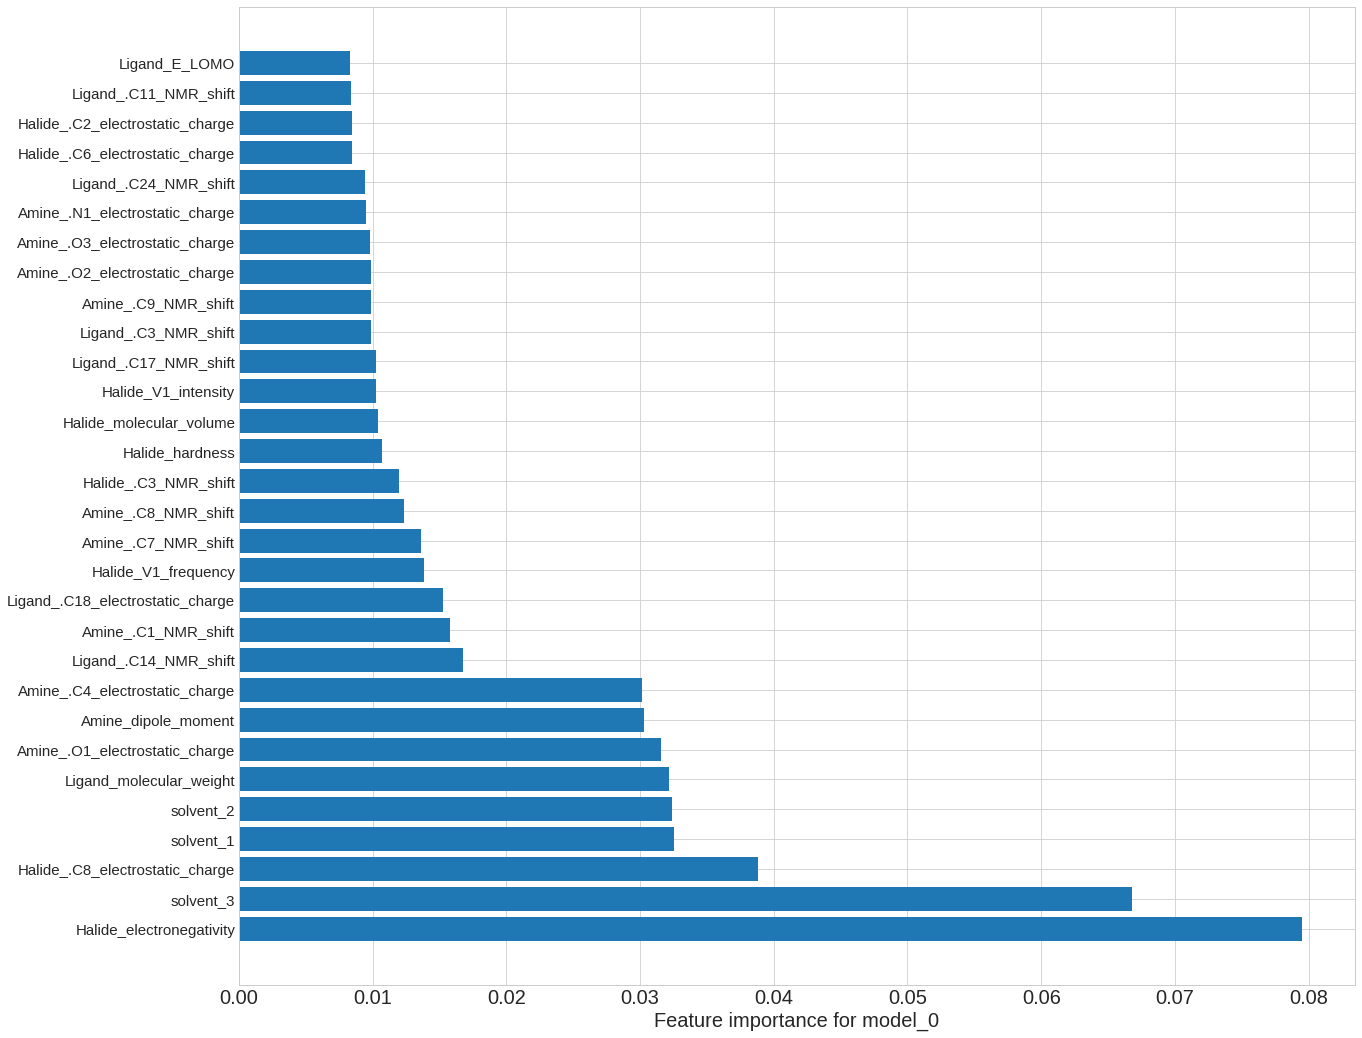

In [13]:
n=30
model_id=0
feat_importances = feat_import_dict[model_id]
sorted_idx = (-feat_importances).argsort()[:n]
feat_names= list(X.columns)

fig, ax = plt.subplots(figsize=(20,18))

ax.tick_params(axis='x', which='major', labelsize=20)
ax.tick_params(axis='y', which='major', labelsize=15)
ax.set_xlabel('Feature importance for model_'+str(model_id),fontsize=20)


selected_feat_names = [feat_names[i] for i in sorted_idx]
selected_feat_importances = feat_importances[sorted_idx]
ax.barh(selected_feat_names, selected_feat_importances)
plt.savefig(path+'figs/RF_model_'+rdkit+'_'+str(model_id)+'_predictors_top_'+str(n)+'.png',dpi=300)